# This tutorial shows how to make a cross spectrum of two light curves using Stingray.

In [78]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

# Cross spectrum example
## 1. Create two light curves
There are two ways to make `Lightcurve` objects. We'll show one way here. Check out "Lightcurve/Lightcurve\ tutorial.ipynb" for more examples.

Generate an array of relative timestamps that's 8 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The first is a sine wave with amplitude = 300 cts, frequency = 2 Hz, phase offset = 0 radians, and mean = 1000 cts. The second is a sine wave with amplitude = 200 cts, frequency = 2 Hz, phase offset = pi/4 radians, and mean = 900 cts. We then add Poisson noise to the light curves.

In [79]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal_1 = 300 * np.sin(2.*np.pi*times/0.5) + 1000
signal_2 = 200 * np.sin(2.*np.pi*times/0.5 + np.pi/4) + 900
noisy_1 = np.random.poisson(signal_1)
noisy_2 = np.random.poisson(signal_2)

Now let's turn noisy_1 and noisy_2 into `Lightcurve` objects.

In [80]:
lc1 = Lightcurve(times, noisy_1)
lc2 = Lightcurve(times, noisy_2)

Here we're plotting them to see what they look like.

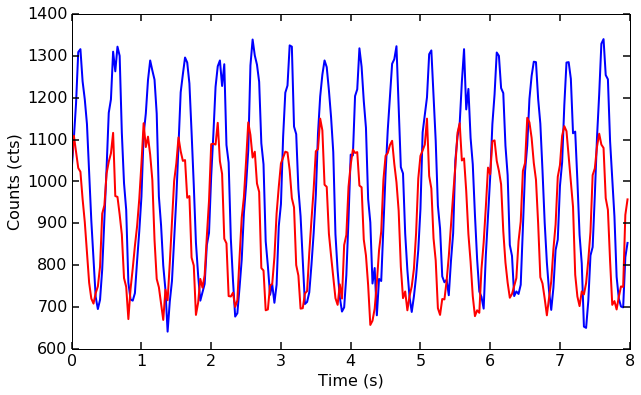

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc1.time, lc1.counts, lw=2, color='blue')
ax.plot(lc1.time, lc2.counts, lw=2, color='red')
# ax.set_ylim(650, 1350)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

## 2. Pass both of the light curves to the `Crossspectrum` class to create a `Crossspectrum` object.
The first `Lightcurve` passed is the channel of interest or interest band, and the second `Lightcurve` passed is the reference band.
You can also specify the optional attribute `norm` if you wish to normalize the real part of the cross spectrum ('cross power') to squared fractional rms, Leahy, or squared absolute normalization. The default normalization is 'none'.

In [82]:
cs = Crossspectrum(lc1, lc2)
print(cs)

We can print the first five values in the arrays of the positive Fourier frequencies and the cross power. The cross power has a real and an imaginary component. Since the negative Fourier frequencies (and their associated cross powers) are discarded, the number of time bins per segment `n` is twice the length of `freq` and `power`.

In [83]:
print(cs.freq[0:5])
print(cs.power[0:5])
print("\nSize of positive Fourier frequencies:", len(cs.freq))
print("Number of data points per segment:", cs.n)

[ 0.125  0.25   0.375  0.5    0.625]
[   9916.39347418 -75586.81549373j   48855.17406145 -13542.92110652j
  -57041.93408159+223754.09379967j -112995.65228919+443737.85450525j
   39759.38061882 -34897.75719364j]

Size of positive Fourier frequencies: 127
Number of data points per segment: 256


# Properties
A `Crossspectrum` object has the following properties :

1. `freq` : Numpy array of mid-bin frequencies that the Fourier transform samples.
2. `power` : Numpy array of the cross spectrum (complex numbers).
3. `df` : The frequency resolution.
4. `m` : The number of averaged cross spectra. For a `Crossspectrum` of a single segment, `m=1`.
5. `n` : The number of data points (time bins) in one segment of the light curves.
6. `nphots1` : The total number of photons in the first (interest) light curve.
7. `nphots2` : The total number of photons in the second (reference) light curve.

We can compute the amplitude of the cross spectrum, and plot it as a function of Fourier frequency. Notice how there's a spike at our signal frequency of 2 Hz!

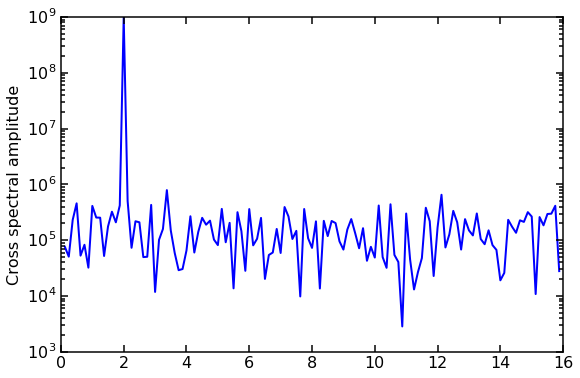

In [84]:
cs_amplitude = np.abs(cs.power)  # The mod square of the real and imaginary components

fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(cs.freq, cs_amplitude, lw=2, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Cross spectral amplitude", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

You'll notice that the cross spectrum is a bit noisy. This is because we're only using one segment of data. Let's try averaging together multiple segments of data.
# Averaged cross spectrum example
You could use two long `Lightcurve`s and have `AveragedCrossspectrum` chop them into specified segments, or give two lists of `Lightcurve`s where each segment of `Lightcurve` is the same length. We'll show the first way here.
## 1. Create two long light curves.
Generate an array of relative timestamps that's 1600 seconds long, and two signals in count units, with the same properties as the previous example. We then add Poisson noise and turn them into `Lightcurve` objects.

In [85]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

long_signal_1 = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000
long_signal_2 = 200 * np.sin(2.*np.pi*long_times/0.5 + np.pi/4) + 900

long_noisy_1 = np.random.poisson(long_signal_1)
long_noisy_2 = np.random.poisson(long_signal_2)

long_lc1 = Lightcurve(long_times, long_noisy_1)
long_lc2 = Lightcurve(long_times, long_noisy_2)

## 2. Pass both light curves to the `AveragedCrossspectrum` class with a specified `segment_size`.
If the exposure (length) of the light curve cannot be divided by `segment_size` with a remainder of zero, the last incomplete segment is thrown out, to avoid signal artefacts. Here we're using 8 second segments.

In [86]:
avg_cs = AveragedCrossspectrum(long_lc1, long_lc2, 8.)

Again we can print the first five Fourier frequencies and first five cross spectral values, as well as the number of segments.

In [87]:
print(avg_cs.freq[0:5])
print(avg_cs.power[0:5])
print("\nNumber of segments:", avg_cs.m)

[ 0.125  0.25   0.375  0.5    0.625]
[-19513.65378157 -9304.95811626j   -130.67661774 -5956.24525303j
  13053.40174080-12772.51036833j   4916.45974469 +6406.57238108j
   8271.37209806+12127.19142061j]

Number of segments: 200


If `m` is less than 50, a warning will pop up letting you know that your number of segments is significantly low, so the computed `coherence` function and error on `coherence` might not follow the expected (Gaussian) statistical distributions.

# Properties
An `AveragedCrossspectrum` object has the following properties :

1. `freq` : Numpy array of mid-bin frequencies that the Fourier transform samples.
2. `power` : Numpy array of the averaged cross spectrum (complex numbers).
3. `df` : The frequency resolution (in Hz).
4. `m` : The number of averaged cross spectra, equal to the number of whole segments in a light curve.
5. `n` : The number of data points (time bins) in one segment of the light curves.
6. `nphots1` : The total number of photons in the first (interest) light curve.
7. `nphots2` : The total number of photons in the second (reference) light curve.

Let's plot the amplitude of the averaged cross spectrum!

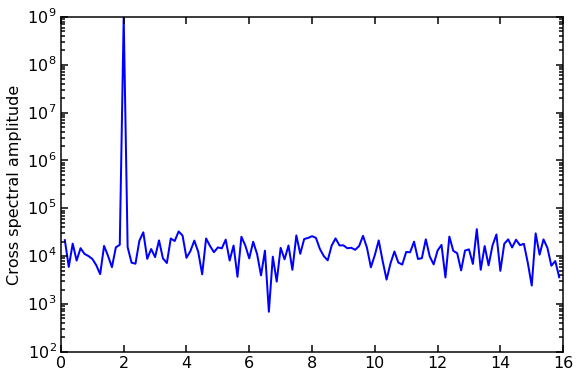

In [88]:
avg_cs_amplitude = np.abs(avg_cs.power)

fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(avg_cs.freq, avg_cs_amplitude, lw=2, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Cross spectral amplitude", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

# Re-binning a cross spectrum in frequency
## 1. We can linearly re-bin a cross spectrum
(although this is not done much in practice)

In [121]:
print(avg_cs.df)
#lin_rb_cs = Crossspectrum.rebin(avg_cs, 0.25, method='mean')
# lin_rb_cs = avg_cs.rebin(0.25, method='mean')
# log_rb_cs = Crossspectrum.rebin_log(avg_cs, f=0.02)
# log_rb_cs = avg_cs.rebin_log(f=0.02)

0.125
